Loading required package: ggplot2



,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X92,X93,X94,X95,X96,X97,X98,X99,X100,y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4.486080,5.863946,4.5570774,4.860536,8.2511191,8.3830886,8.673599,2.0478729,6.8709846,9.534902,⋯,5.423933,9.463360,2.1718483,5.580840,3.3012387,8.2793815,4.8300304,2.681033,9.7033566,10.81895
2,7.349340,3.990786,0.0277599,7.640621,2.5756204,8.6857847,6.162933,5.4491966,5.7948239,4.670754,⋯,9.058452,1.175340,3.4858504,9.657511,2.5623760,4.3429097,0.4829740,6.408655,7.0590511,146.73731
3,7.873617,9.483111,5.0576903,6.369655,1.2615458,0.8086937,7.601771,0.4832078,5.0003614,6.074024,⋯,8.945969,5.493883,5.3067593,4.989120,4.1874812,6.4130095,8.4177072,2.118511,0.7013359,50.50614
4,3.875380,5.729264,5.6949816,8.880188,3.3264814,8.0637251,6.418470,2.4460057,7.1824969,4.767969,⋯,9.421983,9.603880,9.8977837,2.336864,0.1161057,0.2385075,5.0569152,3.330938,5.6228421,121.18108
5,9.414156,8.688797,9.5843429,3.352147,0.2801729,8.9814584,4.546106,4.8865015,1.4772557,8.252231,⋯,6.014563,9.382942,1.2316932,8.104649,3.1722069,4.2388700,0.2189814,3.692163,1.0645302,29.91417
6,2.290216,1.098556,9.3342363,5.406841,1.5416912,4.5189936,7.014252,3.3364917,0.7727947,7.755669,⋯,5.661278,6.684998,0.1788062,2.920011,0.2753109,6.1925108,1.5730593,6.240513,3.5744232,41.11726


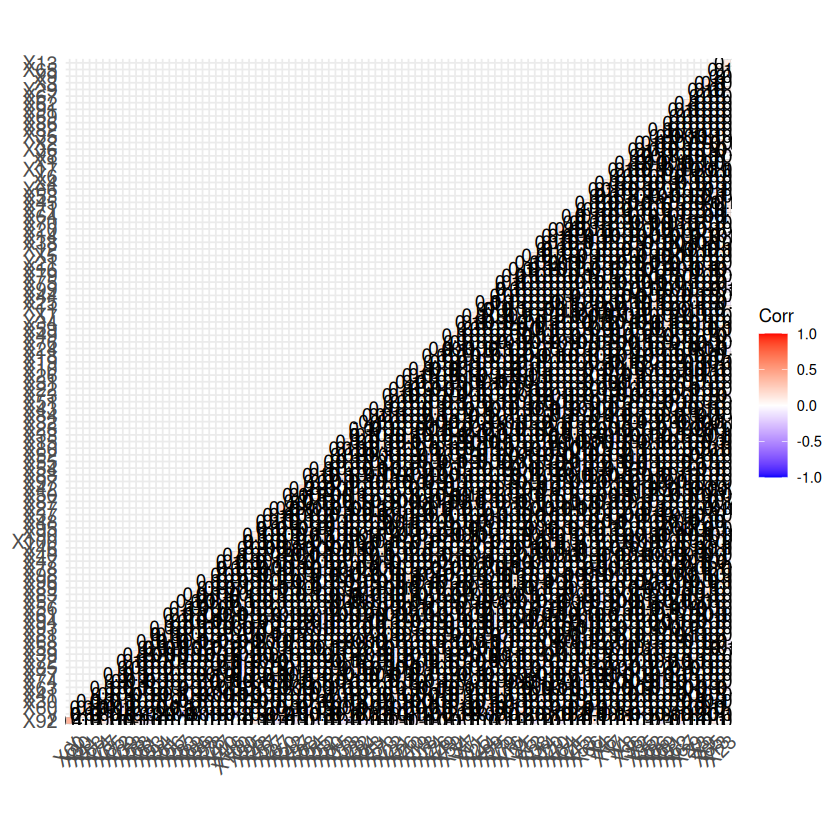

In [13]:
# Replace 'your_file.csv' with the path to your regression data file
library(ggcorrplot)
library(ggpl)
file_path = './a24_reg_app.txt'
X.clas = read.delim(file = file_path, header = TRUE, sep = " ")
# Display the first few rows of the dataframe
head(X.clas)
#plot correlation matrix
corr <- round(cor(X.clas), 1)
ggcorrplot(corr, hc.order = TRUE, type = "lower",
   lab = TRUE)